In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing

In [2]:
import RouteMap as rm
import BusModel as bm
import Helper_Methods as hm

In [3]:
route = 22
concat_val = 6
period = "AM"

In [4]:
route_path = "./Data/Routes/rt{}_pts.shp".format(route)
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
signals_path = "./Data/Signals/Traffic_Signals.shp"
seattle_streets_data = "./Data/Seattle_Streets/Seattle_Streets.shp"

route_raw = gpd.read_file(route_path)
stops = gpd.read_file(stops_path)
signals = gpd.read_file(signals_path)
seattle_streets = gpd.read_file(seattle_streets_data)

In [102]:
route_concat = route_raw[::6]
route_concat = route_concat.reset_index(drop=True)

route_geometry = route_concat['geometry']
route_elevation = route_concat['Z']
all_stops = stops.copy()
all_signals = signals['geometry'].reset_index(drop=True)
route_stops = hm.get_stops(all_stops, str(route))['geometry'].reset_index(drop=True)
limits = seattle_streets[['geometry', 'SPEEDLIMIT']]

43 43


In [105]:
#route_test_map = rm.RouteMap(route_geometry, route_elevation, limits, route_stops, all_signals, debug = True)
#(route_test_map.get_gdf()).to_csv('sample_22.csv')

DEBUGGER ACTIVE
speeds assignedmainnnn
stops assigned
signals assigned


In [117]:
route_test_map = rm.RouteMap(route_geometry, route_elevation)
route_test_map = route_test_map.load_from_gdf('rt22.csv')

C:\Users\Sebastian\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, 'Distance vs. Elevation and Grade')

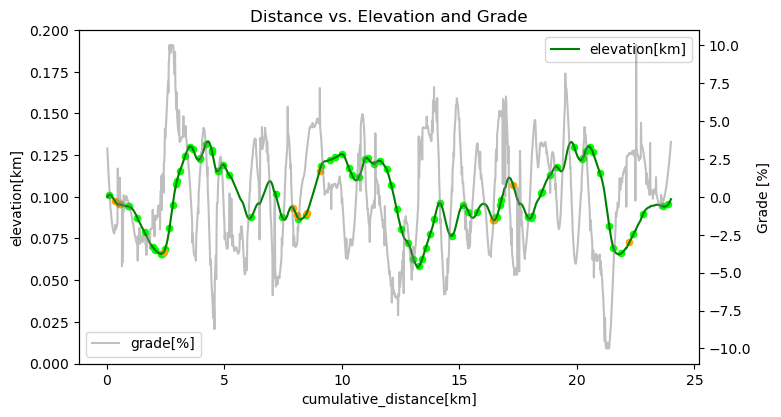

In [118]:
sm_elev = route_test_map.smooth_elevation()
route_sm_map = route_test_map.set_elevation(sm_elev)
route_sm_map.plot()
plt.title('Distance vs. Elevation and Grade')

# Swap grade to true percent and not fractional

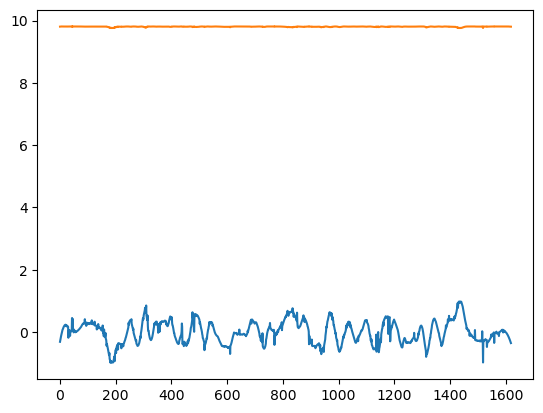

In [119]:
y = route_test_map.get_hill_accel()
x = route_test_map.get_hill_accel().index
y2 = route_test_map.get_fric_accel()
x2 = route_test_map.get_fric_accel().index
plt.plot(x, y)
plt.plot(x2, y2)

In [120]:
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"

kcm_ridership = pd.read_csv(ridership_path)
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

route_data = kcm_ridership[(kcm_ridership['Route']==route) & (kcm_ridership['Period']==period)]

In [121]:
sorted_route = route_data.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
sorted_route = sorted_route[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
sorted_route = sorted_route.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
sorted_route = sorted_route.drop_duplicates(subset='STOP_ID', keep='first')
sorted_route = sorted_route.reset_index(drop = True)
sorted_route['Index'] = sorted_route.index

a_prof = raw_acc_prof.copy()
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

In [122]:
import pandas as pd
import numpy as np

class Bus_Model:
    def __init__(self,
                 acceleration_profile, # two column dataframe containing time(s), accel(m/s^2)
                 raw_mass = 13041, # kilograms, unknown bus model
                 bus_width = 2.6, # meters, unknown bus model
                 bus_height = 3.3, # meters, unknown bus model
                 drag_coeff = 0.6, # default from unknown bus model
                 wheel_rad = 0.5, # meters, unknown bus model
                 factor = 1.1, # intertial factor.
                 fric_coeff = .01, # default from erica's
                 motor_eff = .916, # unknown source
                 invert_eff = .971, # unknown source
                 max_power = 160, # kW
                 regen = .6, # unknown source
                 eff_aux = .89, # unknown source
                 a_braking = -1.5, #m/s^2
                 final_a = .4, # m/s^2, defualt acceleration after profile finishes
                 max_velocity = 26.8224, # m/s, = 60 mph
                 maintain_acceleration = False, # boolean for if bus should maintain the last a in 
                                                # profile or use final_a for extrapolating new vals
                 num_starting_passengers = 0,
                 pass_ave_mass = 80, #kg
                
                 ):
        # raw bus characteristics
        self._empty_mass = raw_mass
        self._bus_width = bus_width
        self._bus_height = bus_height
        self._bus_front_area = self._bus_width * self._bus_height
        self._drag_coeff = drag_coeff
        self._wheel_rad = wheel_rad
        self._i_factor = factor
        self._fric_coeff = fric_coeff
        self._motor_eff = motor_eff
        self._invert_eff = invert_eff
        self._max_power = max_power
        self._regen = regen
        self._eff_aux = eff_aux
        
        # driving model characteristics
        self._a_braking = a_braking
        self._final_a = final_a
        self._final_a_boolean = maintain_acceleration
        self._max_v = max_velocity
        self._accel_profile_df = self.interpret_accel_prof(acceleration_profile)
        
        # variables based on position in route
        self._passengers = num_starting_passengers
        self._mass_p_pass = pass_ave_mass
        self._current_velocity = 0
        self._current_accel = 0
        self._distance_traveled = 0
        self._bus_status = "Stopped"
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        
        
    def interpret_accel_prof(self, accel_prof):
        """
        interpret_accel_prof is used to format the acceleration
        profile so as to have velocity and distance traveled.
        
        Parameters:
        accel_prof: dataframe of time and acceleration values,
                    in seconds and m/s^2.
        
        Returns: 
        dataframe of time, acceleration, velocity, and distance
        in seconds and meters units.
        """
        # Generate a copy of the profile
        acc_prof = accel_prof.copy()
        
        # Get the changes in time
        acc_prof['dt'] = acc_prof['time[s]'].diff()
        
        # use mean_integral to get the velocity data
        acc_prof['vel.[m/s]'] = self.mean_integral(acc_prof['dt'], acc_prof['accel.[m/s^2]'])
        
        # use mean_integral to get the distance data
        acc_prof['dist.[m]'] = self.mean_integral(acc_prof['dt'], acc_prof['vel.[m/s]'])
        
        while (not (acc_prof['vel.[m/s]'].iloc[-1] >= self._max_v)):
            
            # Generate a new row dictionary from the columns
            new_row = dict.fromkeys(list(acc_prof.columns))
            
            # set the step time to be 1 second
            d_t = 1
            
            # calculate the next time point using the previous and dt
            next_time = acc_prof['time[s]'].iloc[-1] + d_t 
            
            # default to using the _final_a acceleration
            next_accel = self._final_a
            
            # if the parameters say to maintain acceleration,
            if self._final_a_boolean:
                # Keep the last acceleration
                next_accel = acc_prof['accel.[m/s^2]'].iloc[-1]
            
            # calculate the next velocity
            next_v = acc_prof['vel.[m/s]'].iloc[-1] + d_t*next_accel
            
            # calculate the next distance
            next_d = acc_prof['dist.[m]'].iloc[-1] + d_t * (next_v + acc_prof['vel.[m/s]'].iloc[-1]) / 2
            
            # generate the list of data
            data = [next_time, next_accel, d_t, next_v, next_d]
            
            # put the data into the dictionary
            for i in range(len(data)): new_row[list(new_row.keys())[i]] = data[i]
            
            # Append the new row on to the profile dataframe
            acc_prof.loc[len(acc_prof)] = new_row
            
        # drop the dt column
        #acc_prof = acc_prof.drop(columns = ['dt'])
        
        # return the acceleration profile dataframe
        return acc_prof
    
    
    def mean_integral(self, time_changes, value_series):
        """
        mean_integral takes in a series of dt (s) values, and
        a corresponding series of other values to be integrated
        with respect to time, and provides the result as a
        cumulative summing series. 

        Parameters:
        time_changes: a pandas series of dT values in units of seconds
        value_series: a pandas series of d[value] that has relation to time.

        Returns: 
        a pandas series of the integrated values.
        """
        int_prof = pd.DataFrame()
        int_prof['mean_val_btw'] = value_series.rolling(window=2).mean()
        int_prof['d[value]'] = int_prof['mean_val_btw'] * time_changes
        int_prof['integrated'] = int_prof['d[value]'].cumsum()

        return int_prof['integrated'].fillna(0)
    
    
    def get_accel_profile(self):
        return self._accel_profile_df
    
    
    def velocity(self):
        return self._current_velocity
    
    
    def set_v(self, v):
        self._current_velocity = v
    
    
    def max_velocity(self):
        return self._max_v
    
    def accelerate(self, dist):
        
        # Get current velocity
        prev_v = self._current_velocity
        
        # get a copy of the acceleration profile
        prof = self.get_accel_profile().copy()
        
        prof['force[N]']=self._current_mass*prof['accel.[m/s^2]']
        prof['force[N]']=prof['force[N]'].cumsum()
        
        prof['energy[J]'] = prof['force[N]']*(prof['dist.[m]'].shift(-1))
        prof['power[W]'] = prof['energy[J]']*(prof['dt'].shift(-1))
        
        # get the closest velocity in the acceleration profile
        closest_v = prof.iloc[(prof['vel.[m/s]'] - prev_v).abs().argsort()[:1]]
        
        
        # get the index of the closest velocity in the profile
        starting_index = (list(closest_v.index))[0]
        
        # generate an acceleration distance column based on the starting point of closest v
        prof['accel_dist'] = prof['dist.[m]'] - int(closest_v['dist.[m]']) - dist
        
        # zero the velocity to the current velocity
        zeroed_v = prof.iloc[(prof['accel_dist'] - 0).abs().argsort()[:1]]
        
        # get the final index of the zeroed v
        final_index = (list(zeroed_v.index))[0]
        
        # set the current velocity to the final index of the acceleration
        self._current_velocity = prof['vel.[m/s]'][final_index]
        force_applied = prof['force[N]'][final_index] - prof['force[N]'][starting_index] 
        time_taken = prof['time[s]'][final_index] - prof['time[s]'][starting_index] 
        
        # set the distance traveled to the sum of the previous value and the
        # travel distance
        self._distance_traveled = dist + self._distance_traveled
        
        # change bus status
        self._bus_status = 'moving'
        
        accelerate_energy_raw = force_applied*dist
        
        power_used = accelerate_energy_raw/time_taken # Watts
        
        return (accelerate_energy_raw, power_used)
    
    def accelerate_v2(self, dist):
        def find_dx(v0, a, d): return (v0*dt + (1/2)*a*(dt**2))
        def find_new_v(v0, a, dt): return (v0 + a*dt)
    
        prev_v = self._current_velocity
        prof = self.get_accel_profile().copy()

        prof.at[0, 'vel.[m/s]'] = prev_v 
        
        prof['force[N]']=self._current_mass*prof['accel.[m/s^2]']
        prof['energy[J]'] = 0
        prof['power[W]'] = 0
        prof['dx[m]'] = 0
        
        accelerated_dist = 0
        i=0
        while ((dist > accelerated_dist) & (prof['power[W]'].iloc[i] < self._max_power*1000)):
            v0 = prof['vel.[m/s]'][i]
            a = prof['accel.[m/s^2]'][i]
            dt = prof['dt'][i+1]
            dx = v0*dt + (1/2)*a*(dt**2)
            vf = np.sqrt(v0**2 + 2*a*dx)
            prof.at[i+1, 'vel.[m/s]'] = vf
            prof.at[i+1, 'dx[m]'] = dx
            prof.at[i+1, 'energy[J]'] = prof['force[N]'][i+1]*dx
            prof.at[i+1, 'power[W]']= prof['energy[J]'].iloc[i+1]/dt
            accelerated_dist += dx
            i+=1
        final_v = prof['vel.[m/s]'].iloc[i]
        self._current_velocity = final_v
        self.distance_traveled = dist + self._distance_traveled
        self._bus_status = 'moving'
        
        
        accelerate_energy_raw = prof['energy[J]'].cumsum()[i]
        power_used = prof['power[W]'].cumsum()[i]/i # Watts
        return(accelerate_energy_raw, power_used)
        
        
    def brake(self, dist, braking_factor):
        v0 = self._current_velocity
        braking_acc = self._a_braking*braking_factor
        v2 = v0**2
        dv2 = braking_acc*dist*2
        final_v = 0
        if (v2>np.abs(dv2)):
            #print(v2 + dv2)
            final_v = np.sqrt(v0**2 + 2*braking_acc*dist)
        self._current_velocity = final_v
        braking_force = braking_acc*self._current_mass
        self._current_accel = braking_acc
        braking_energy_raw = braking_force*dist
        
        power_calc = braking_energy_raw/((final_v - v0)/braking_acc)
        
        return (braking_energy_raw, power_calc)
    
    
    def maintain(self, dist, ext_acc):
        
        # The current external acceleration from what was passed
        current_ext_acc = ext_acc
        
        # Get current bus mass
        cur_mass = self._current_mass
        
        # get the external force from the mass and acceleration
        ext_force = cur_mass * current_ext_acc
        
        # get the force of inertia
        in_force = self.get_inertial_force()
        
        # The engine force should compensate to balance
        # the difference between the inertia and the external force
        eng_force = -(ext_force)
        
        # get the energy to maintain the force for the distance
        maintain_energy_raw = eng_force*dist
        
        dt = dist/self._current_velocity
        
        power_calc = maintain_energy_raw/dt
        
        # return the energy value
        return (maintain_energy_raw, power_calc)
    
    
    def get_braking_distance(self, velocity, ext_acc):
        
        # Using the kinematics equation vf^2 = vi^2 + 2a(dX) to get
        # braking distance
        return -1*round((velocity**2 / (2*(self._a_braking - ext_acc))), 5) # Convert to meters

    
    def get_aerodynamic_drag(self, wind_speed, air_density):
        air_drag = (self._drag_coeff * self._bus_front_area * (air_density/2) * (self._current_velocity - wind_speed)**2)/self._current_mass
        return air_drag # acceleration of air drag
    
    
    def get_inertial_force(self):
        inertia = self._i_factor * self._current_mass * self._current_accel
        return inertia # Force of inertia
    
    
    def update_riders(self, val, cat='change'):
        # Update passenger number, sum should never be < 0
        
        if (cat=='change'):
            self._passengers = self._passengers + val
        elif (cat == 'set'):
            self._passengers = val
        
        # Update total mass
        self._current_mass = self._empty_mass + self._passengers * self._mass_p_pass
        return None
    
    def get_n_riders(self):
        return self._passengers
    
    def get_mass(self):
        return self._current_mass
    
    def get_fric_coeff(self):
        return self._fric_coeff

    def get_b_accel(self):
        return self._a_braking

In [123]:
default_bus = Bus_Model(a_prof)
while (default_bus.velocity() < 10):
    en, powr = default_bus.accelerate_v2(14.985273207016998)
    print(powr)

39342.766129904514
109135.82084380479
135770.82161350525
154165.73227669197


In [134]:
import random
class Trip_Dynamics:
    def __init__(self, route_map, bus_model, bus_ridership, ridership_type='mean', seed=None):
        self._route_map = route_map
        self._bus_model = bus_model
        self._ridership_type = ridership_type
        self._rand_seed = seed
        if (self._ridership_type == 'mean'):
            self._ridership = bus_ridership
        elif (self._ridership_type == 'chance'):
            self._ridership = self.riders_from_chance(bus_ridership)
        self._route_data = self._route_map.get_gdf()
        self._route_data['riders'] = self.generate_rider_profile()
        #self._route_data['f_bus'] = self.bus_trip_force()
        self._route_data['bus_mass'] = self.generate_mass_profile()
        self._route_data['f_grav'] = self._route_data['bus_mass'] * self._route_map.get_hill_accel()
        self._route_data['f_fric'] = self._route_data['bus_mass'] * self._route_map.get_fric_accel()  * self._bus_model.get_fric_coeff() 
        
    
    def _riders_from_chance(self, ridership_probs):
        '''
        UNFINISHED
        riders_from_chance takes in a series of probabilities for a change in
        ridership of x of the bus, and returns a series of
        changes in bus ridership that corresponds
        '''
        np.random_seed(self._rand_seed)
        deltas = [0, 1]
        
    
    def generate_rider_profile(self):
        '''
        generate_rider_profile generates a pandas series that contains the
        current amount of riders based on bus position
        
        Parameters:
        None
        
        Returns:
        pandas series matching length of route, with ridership numbers.
        Indicies identical to the route.
        '''
        
        # Copy the ridership changes as d_riders
        d_riders = self._ridership.copy()
        
        # get the series of stop booleans for the route
        stop_bools = self._route_data['is_stop'].copy()
        
        # create a new dataframe based on the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # default change in riders is 0
        df['d_riders'] = 0
        
        # get a list of indexes on the route that are stops
        stop_indexes = list(df[df['is_stop']==True].index)
        
        # At the stops, add the change in riders
        df.iloc[stop_indexes, df.columns.get_loc('d_riders')] = d_riders
        
        # make the cumulative riders and return it
        df['riders'] = df['d_riders'].cumsum()
        return df['riders']
    
    

    def generate_mass_profile(self):
        '''
        generate_mass_profile generates a pandas series
        containing the total bus mass at each point along
        the trip, based on the ridership information of the route.
        
        Parameters:
        None
        
        Returns:
        a pandas series containing the total bus mass
        at each point on the route, indexed the same.
        '''
        
        # Copy the stops and riders
        stop_bools = self._route_data['is_stop'].copy()
        n_riders = self._route_data['riders'].copy()
        
        # Generate a new dataframe from the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # Add the default bus mass to the dataframe
        df['total_mass'] = self._bus_model.get_mass()
        
        # add the ridership column to the dataframe
        df['n_riders'] = n_riders
        
        # get stop indexes
        stop_indexes = df[df['is_stop']==True].index
        
        # Get the column indexes of mass and riders
        mass_col_id = df.columns.get_loc('total_mass')
        rider_col_id = df.columns.get_loc('n_riders')
        
        # Loop through each stop,
        for i in range(len(stop_indexes)):
            
            # Get the current route point index
            cur_idx = stop_indexes[i]
            
            # get the ridership value for this index
            rider_val = df.iloc[cur_idx, rider_col_id]
            
            # Set the bus model's riders to the rider value
            self._bus_model.update_riders(rider_val, 'set')
            
            # Get the mass of the bus model
            df.iloc[cur_idx:, mass_col_id] = self._bus_model.get_mass()
        
        # return the total mass series
        return df['total_mass']

    
    def get_mass_profile(self):
        return self._route_data['bus_mass']
    

    def bus_trip(self):
        '''
        bus_trip uses the route data and bus information to simulate the bus
        travelling according to a set logic, and returns the route geodataframe with new information
        on acceleration, time, and velocity.
        '''
        
        # get the route geodataframe
        route = self._route_map.get_gdf()
        
        # Get get the stop boolean column, setting the final
        # two positions to stops to help ensure proper completion.
        #route['is_stop'][:-2] == True
        
        # get the frictional acceleration profile of the route
        fric_a_prof = self._route_map.get_fric_accel()
        
        # get the hill accelerational profile of the route
        hill_a_prof = self._route_map.get_hill_accel()
        
        # get the bus model
        bus = self._bus_model
        
        # get the friction coefficient of the bus model
        bus_f_coef = bus.get_fric_coeff()
        
        # get the maximum velocity for the defined bus
        max_v = bus.max_velocity()
        
        # define new columns for velocity, stop distance, state, and stopping distance.
        route['vel.[m/s]'] = 0
        route['stop_dist[m]'] = 0
        route['stppn_dist'] = 0
        route['energy_used[J]'] = 0
        route['POWERTEST[W]'] = 0
        route['st'] = 0
        
        # Generate empty lists to hold the velocities, distances, states, and stopping distances.
        vel_list = []
        dist_list = []
        st_ls = []
        stp_d_ls = []
        energy = []
        power = []
        
        # get the accelerational profile of the bus.
        accel_profile = bus.get_accel_profile()
        
        is_stopping=True
        
        # Loop through each point on the route
        for i in range(1, len(route)-1):
            
            # get the current point distance in meters
            point_dist = route['point_distances[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance travelled to this point in meters
            cum_dist = route['cumulative_distance[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance column id
            cum_dist_col_id = route.columns.get_loc('cumulative_distance[km]')
            
            # get the dataframe containing the remaining points that have not been visited
            remaining_trip = route.iloc[i:]
            
            # set the distance to the stop to a dummy variable of 0
            dist_to_stop = 0
            
            # get the list of stops as defined by the distance between each stop on the route,
            #including signals, in meters
            stops_remain = remaining_trip[(remaining_trip['is_stop'] == True) | (remaining_trip['is_signal'] == True)]['cumulative_distance[km]'].reset_index(drop=True)*1000 #convert to meters
            
            # if there are remaining stops,
            if (len(stops_remain) != 0):
                
                # set the distance to the stop to be the difference between the stop distance
                # and cumulative distance
                dist_to_stop = stops_remain[0]-cum_dist # meters
                
            # get the current velocity of the bus
            start_velocity = bus.velocity() 
            
            # get the acceleration of drag, with wind speed of 0 and air density of
            # 1.2 kg/m^3, to be adjustible later
            a_drag = bus.get_aerodynamic_drag(0, 1.2)
            
            # get the acceleration of bus friction at the point
            a_fric = fric_a_prof[i]*bus_f_coef
            
            # get the acceleration due to gravity at the point
            a_hill = hill_a_prof[i]
            
            # combine the accelerations to get external acceleration
            ext_a = a_drag + a_fric + a_hill
            
            # calculate the stopping distance based on the starting velocity and external acceleration
            stopping_dist = bus.get_braking_distance(start_velocity, ext_a) #meters
            
            # get the speed limit at current point
            point_sp_lim = route['speed_limit[km/s]'][i] * 1000 # meters
            
            # set up a variable for status
            status = ""
            d_energy = 0
            d_power = 0
            
            # Driving logic: -------------------------------------------------------
            #If at rest, accelerate for the distance between this and the next point
            if ((start_velocity == 0)):
                def decision(probability): return random.random() < probability
                is_stopping = decision(1)
                status = "accel_from_0"
                d_energy, d_power = bus.accelerate_v2(point_dist)
                
            # If the distance difference between stopping distance and distance to the stop
            # is less than half the point distance resolution, then brake
            #TODO: THIS BRAKING ISNT TOTALLY ACCURATE AND OVERBRAKES SOMETIMES
            # D_energy = Force * dist
            elif ((dist_to_stop < (stopping_dist + point_dist)) and is_stopping):
                status = "Stopping_brake"
                d_energy, d_power = bus.brake(point_dist, .8)
            #elif((dist_to_stop-stopping_dist)<= point_dist):

                
            # If the starting velocity is less than the speed limit, accelerate
            elif(start_velocity < point_sp_lim - point_sp_lim/10):
                status = "speed_lim_accel"
                d_energy, d_power = bus.accelerate_v2(point_dist)
                
            # if the starting celocity is greater than the speed limit, 
            elif(start_velocity > point_sp_lim):
                status = "speed_lim_brk"
                # find the distance needed to reach speed limit
                b_dist = ((point_sp_lim)**2 - start_velocity**2)/2 /(bus.get_b_accel())
                # brake for that distance
                d_energy, d_power = bus.brake(b_dist, .8)
            else:
                status = "maintain_v"
                d_energy, d_power = bus.maintain(point_dist, ext_a)
            # End driving logic ---------------------------------------------------------
            
            
            # Append all the statuses and data to their lists
            st_ls.append(status)
            vel_list.append(bus.velocity())
            dist_list.append(dist_to_stop)
            stp_d_ls.append(stopping_dist)
            energy.append(d_energy)
            power.append(d_power)
        
        # convert the lists and apply them to the respective columns
        route.iloc[1:-1, route.columns.get_loc('stop_dist[m]')] = dist_list
        route.iloc[1:-1, route.columns.get_loc('vel.[m/s]')] = vel_list
        route.iloc[1:-1, route.columns.get_loc('stppn_dist')] = stp_d_ls
        route.iloc[1:-1, route.columns.get_loc('energy_used[J]')] = energy
        route.iloc[1:-1, route.columns.get_loc('POWERTEST[W]')] = power
        route.iloc[1:-1, route.columns.get_loc('st')] = st_ls
        
        
        v1 = route['vel.[m/s]']
        v2 = route['vel.[m/s]'].shift(-1)
        
        route['elapsed_time[s]'] = (v2 + v1 )/2 / (route['point_distances[km]']*1000)
        #POWER APPROXIMATION
        route['Power[W]'] = route['elapsed_time[s]'] * route['energy_used[J]'] 
        
        route['elapsed_time[s]'] = route['elapsed_time[s]'].cumsum()
        
        
        return route
            
        #apply to each point:
        # If velocity is zero, begin accelerating
        # if velocity is = limit, cease accelerating
        # Check if signal is active
        # if distance to next stop is equal to braking dist for current veolcity,
            # brake
        

In [135]:
default_bus = Bus_Model(a_prof)
sorted_route_diff = sorted_route['AveOn'] - sorted_route['AveOff']
td = Trip_Dynamics(route_test_map, default_bus, sorted_route_diff)
trip = td.bus_trip()

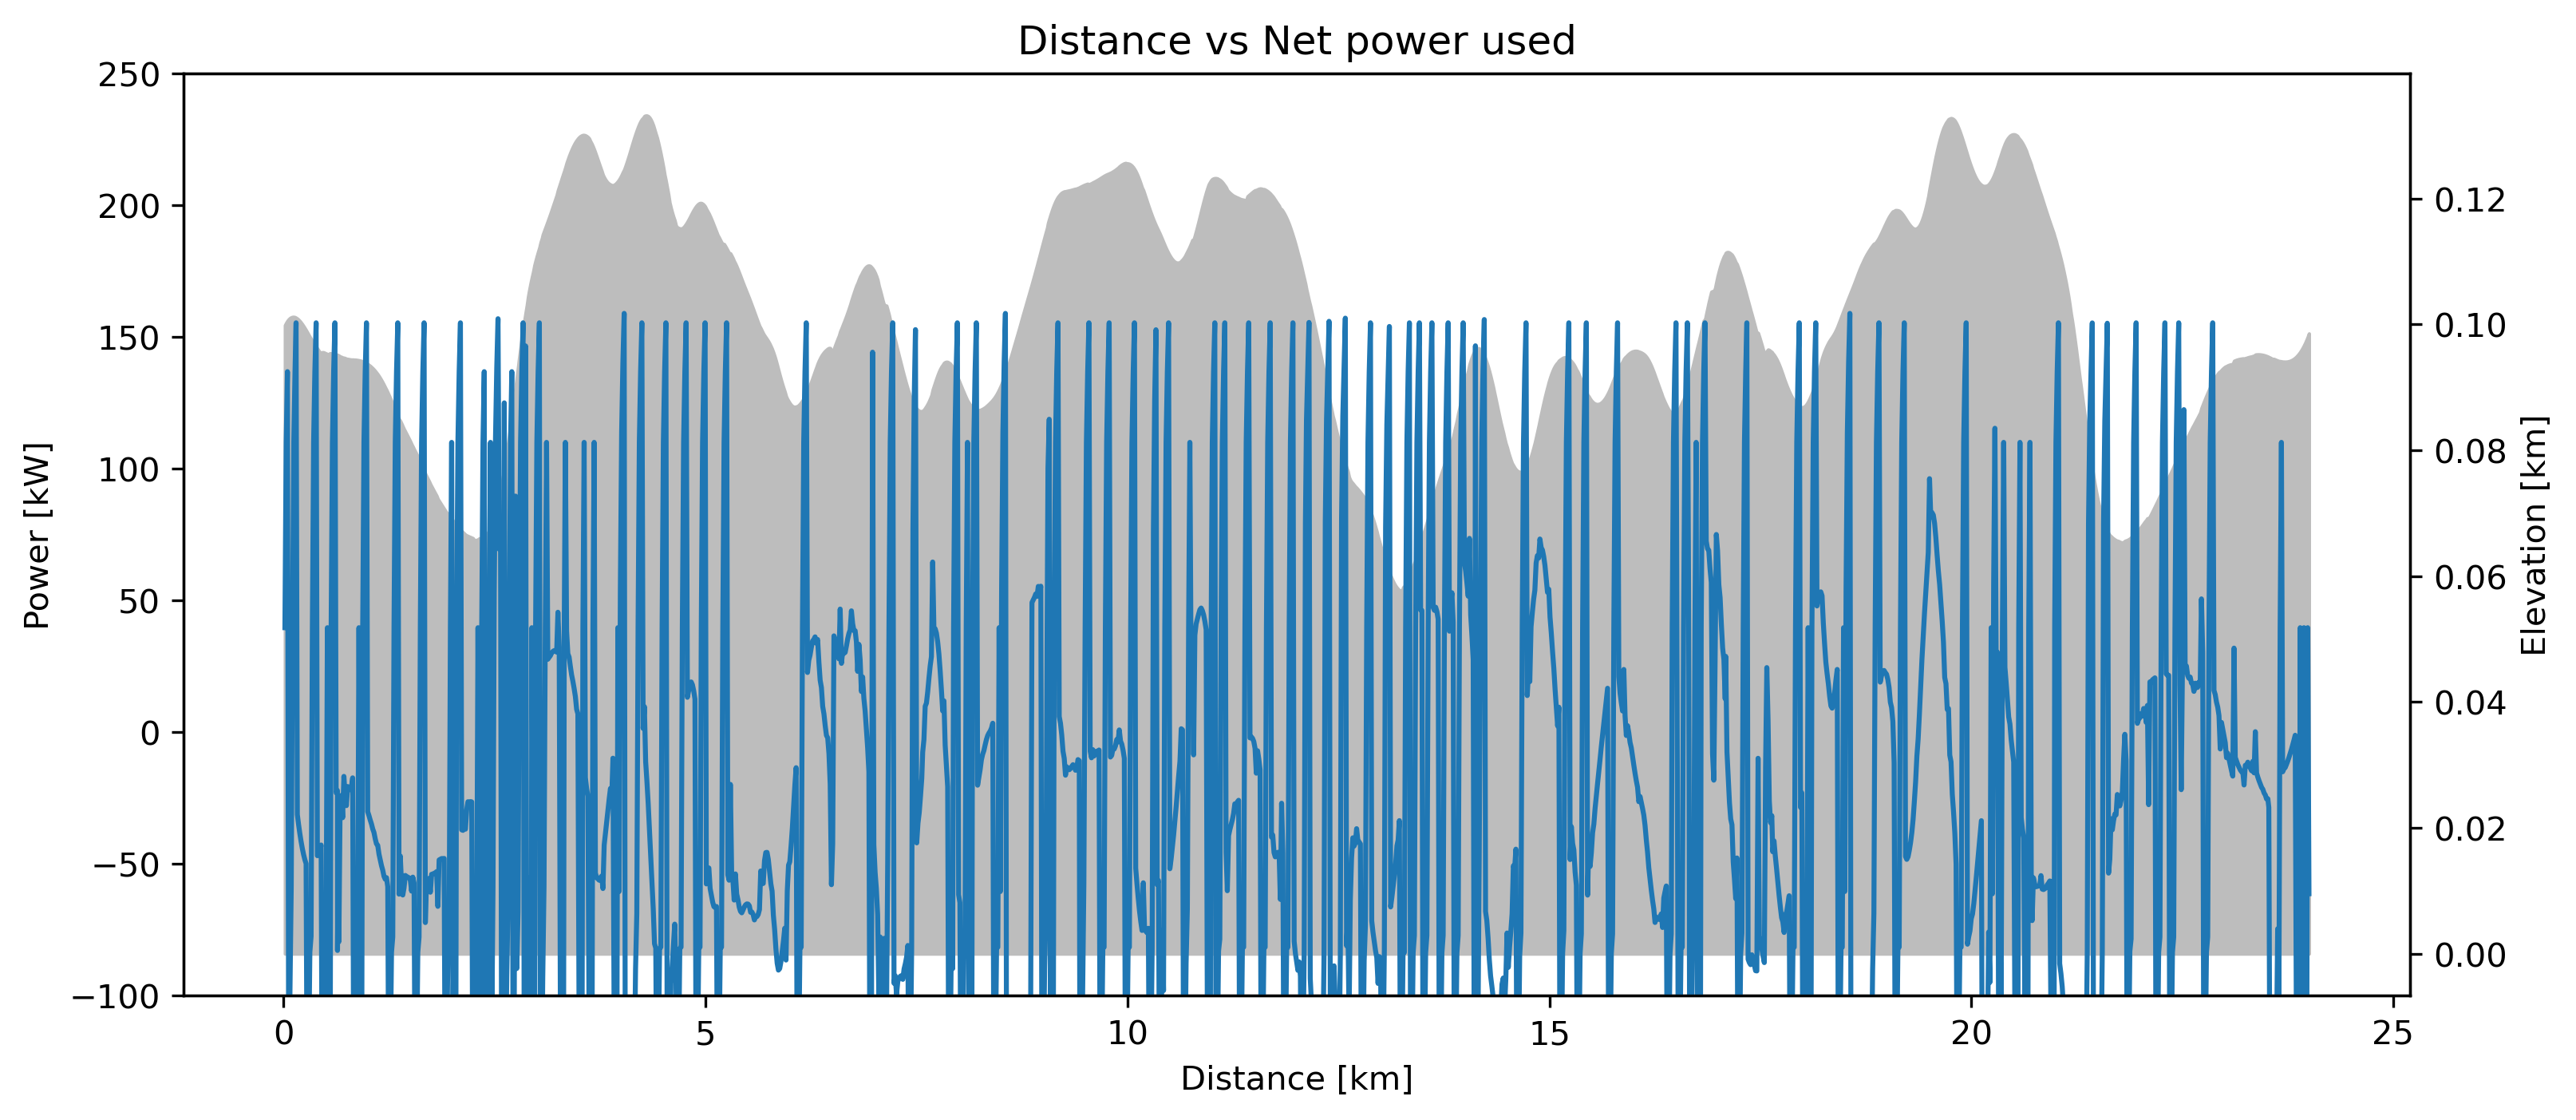

In [136]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


x = trip['cumulative_distance[km]']
y = trip['Power[W]']/1000
fig, ax = plt.subplots(1, figsize = (12,5), dpi=300)
#ax1.fill_between(x, trip['elevation[km]']*1000, color='#BDBDBD')

#ax.plot(x, y)
ax.plot(x, trip['POWERTEST[W]']/1000)
#ax.plot(x, y2, alpha=.5)
#ax.plot(x, trip['POWERTEST[W]']/1000-y2, c='red')
plt.title("Distance vs Net power used")
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Power [kW]")
ax.set_zorder(1)
ax.set_facecolor('none')
ax.set_ylim(-100, 250)
#ax.set_xlim(0,10)
ax1 = ax.twinx()
ax1.fill_between(trip['cumulative_distance[km]'], trip['elevation[km]'], color = '#BDBDBD')
ax1.set_ylabel("Elevation [km]")
ax1.set_zorder(0)


In [94]:
trip

,geometry,elevation[km],latitude,longitude,point_distances[km],cumulative_distance[km],speed_limit[km/s],is_stop,is_signal,grade[%],riders,bus_mass,vel.[m/s],stop_dist[m],stppn_dist,energy_used[J],POWERTEST[W],st,elapsed_time[s],Power[W]
0,POINT (-122.38812865199998 47.56294666500003),0.099398,-122.388129,47.562947,NaN,NaN,0.008941,False,False,NaN,0.0,13041,0.000000,0.000000,0.00000,0.000000,0.000000,0,NaN,NaN
1,POINT (-122.38798249885583 47.56294670020184),0.099875,-122.387983,47.562947,0.014985,0.014985,0.011176,False,False,3.181016,0.0,13041,6.179500,89.911633,0.00000,244405.424156,39656.518732,accel_from_0,0.491508,120127.112883
2,POINT (-122.3878363457117 47.56294673540365),0.100272,-122.387836,47.562947,0.014985,0.029971,0.011176,False,False,2.653140,0.0,13041,8.551250,74.926360,14.17605,323622.962892,110006.162487,speed_lim_accel,1.102224,197641.808754
3,POINT (-122.38769019256756 47.562946770605464),0.100595,-122.387690,47.562947,0.014985,0.044956,0.011176,False,False,2.151487,0.0,13041,9.752250,59.941086,26.03667,271233.104162,136853.573354,speed_lim_accel,1.635753,144710.828120
4,POINT (-122.38754403942342 47.56294680580727),0.100846,-122.387544,47.562947,0.014985,0.059941,0.011176,False,False,1.676057,0.0,13041,6.237917,44.955813,32.65935,-369340.155573,-197053.821790,Stopping_brake,2.131159,-182973.269033
5,POINT (-122.38739788627929 47.56294684100909),0.101030,-122.387398,47.562947,0.014985,0.074926,0.011176,False,False,1.226850,0.0,13041,8.609667,29.970540,13.08489,326321.324247,110924.071200,speed_lim_accel,2.559721,139848.942469
6,POINT (-122.38725173401586 47.56294634063862),0.101150,-122.387252,47.562946,0.014985,0.089912,0.011176,False,False,0.803867,0.0,13041,4.234573,14.985271,24.11934,-369340.044860,-158285.181891,Stopping_brake,2.701012,-52184.490868
7,POINT (-122.38710558186402 47.56294580154749),0.101211,-122.387106,47.562946,0.014985,0.104897,0.011176,True,False,0.407106,0.0,13041,0.000000,0.000000,5.73857,-369340.104462,-163537.801816,Stopping_brake,2.907198,-76152.682232
8,POINT (-122.3869594298198 47.562945233438874),0.101217,-122.386959,47.562945,0.014985,0.119882,0.011176,False,False,0.036568,0.0,13041,6.179500,205.471170,0.00000,244405.424156,39656.518732,accel_from_0,3.398706,120127.129291
9,POINT (-122.3868170033591 47.56292144558612),0.101171,-122.386817,47.562921,0.014802,0.134684,0.011176,False,False,-0.311562,0.0,13041,8.551250,190.669372,11.65894,323622.962892,110006.162487,speed_lim_accel,4.016992,200091.675958


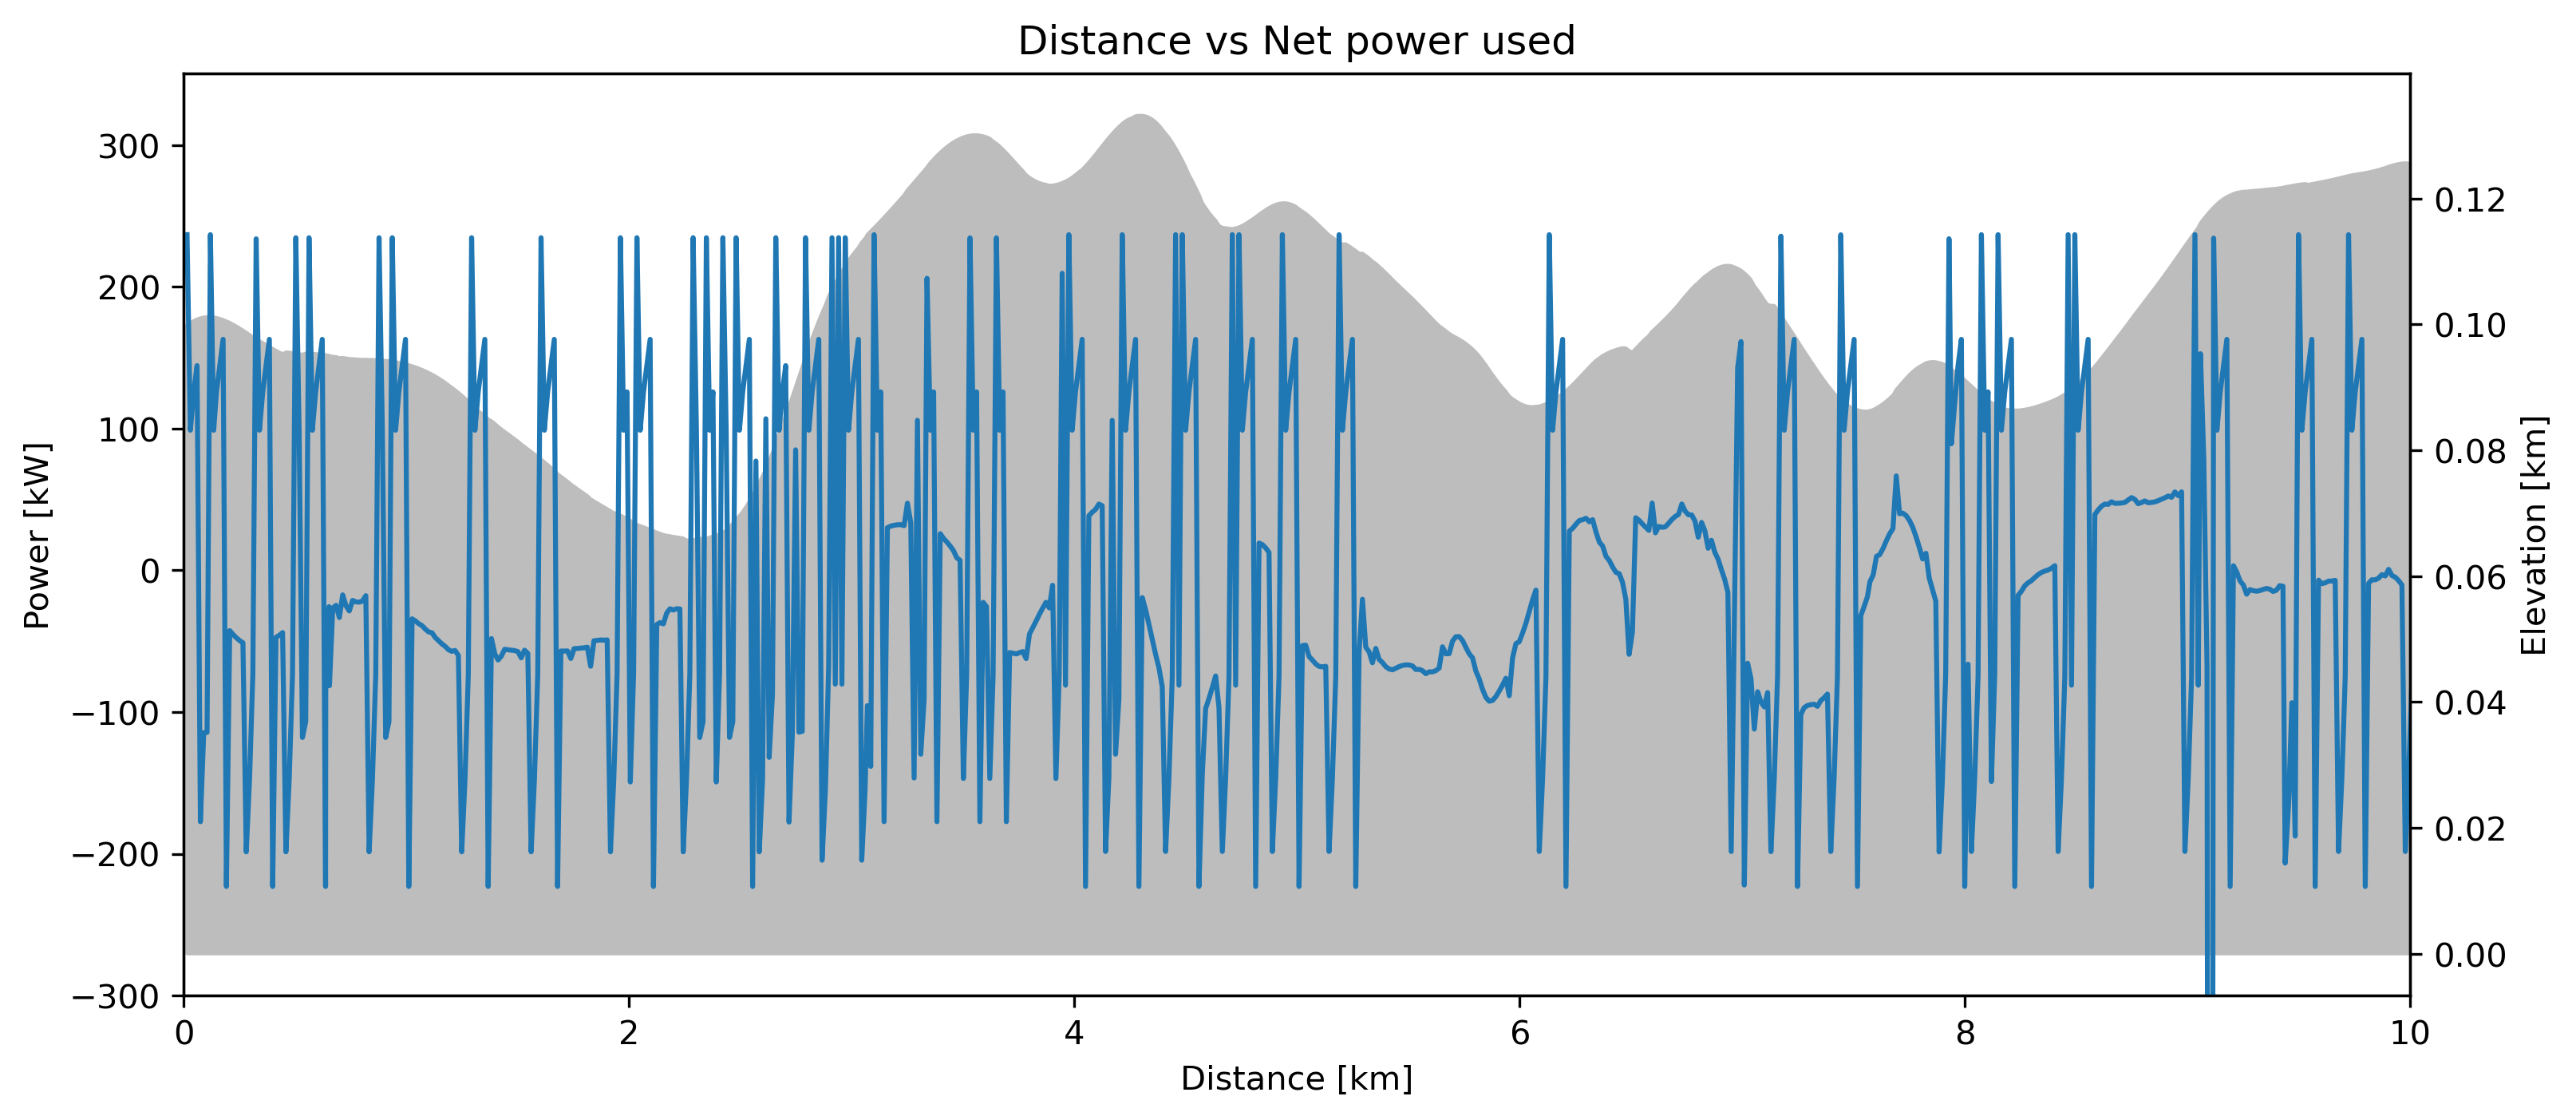

In [45]:
default_bus_2 = Bus_Model(a_prof)
sorted_route_diff = sorted_route['AveOn'] - sorted_route['AveOff']
td2 = Trip_Dynamics(route_test_map, default_bus_2, sorted_route_diff)
trip2 = td2.bus_trip()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


x = trip2['cumulative_distance[km]']
y2 = trip2['POWERTEST[W]']/1000
fig, ax = plt.subplots(1, figsize = (12,5), dpi=300)
#ax1.fill_between(x, trip['elevation[km]']*1000, color='#BDBDBD')

#ax.plot(x, y)
ax.plot(x, y2)
plt.title("Distance vs Net power used")
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Power [kW]")
ax.set_zorder(1)
ax.set_facecolor('none')
ax.set_ylim(-300)
ax.set_xlim(0,10)
ax1 = ax.twinx()
ax1.fill_between(trip['cumulative_distance[km]'], trip['elevation[km]'], color = '#BDBDBD')
ax1.set_ylabel("Elevation [km]")
ax1.set_zorder(0)


In [236]:
stoppp = trip[(trip['is_stop']==True) | (trip['is_signal']==True)]
indexes = stoppp.index
shift_stop = trip.iloc[(indexes - 1)]


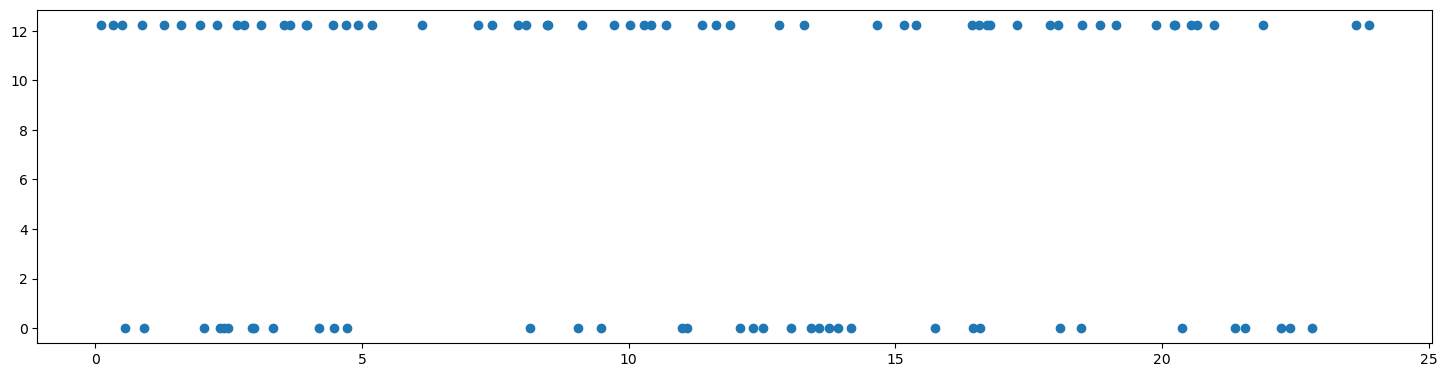

In [237]:
x = stoppp['cumulative_distance[km]']
y = stoppp['vel.[m/s]']*2.236936
fig, ax = plt.subplots(1, figsize = (18, 4.333))
plt.scatter(x, y)

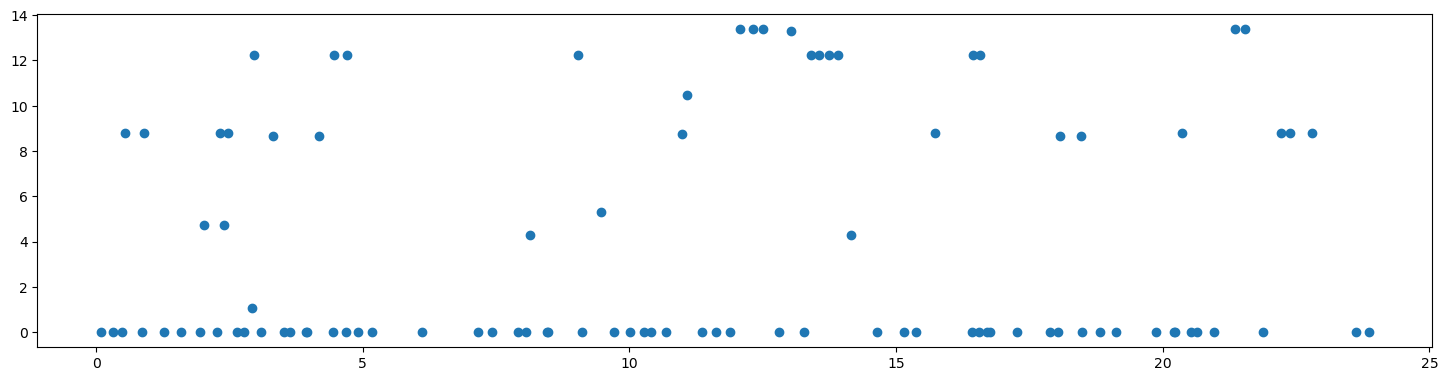

In [238]:
x = shift_stop['cumulative_distance[km]']
y = shift_stop['vel.[m/s]']*2.236936
fig, ax = plt.subplots(1, figsize = (18, 4.333))
plt.scatter(x, y)

In [244]:
len(stoppp[(stoppp['vel.[m/s]']*2.236936 != 0)])

59

In [243]:
len(shift_stop[(shift_stop['vel.[m/s]']*2.236936 == 0)])

59